In [3]:
import os
import random
import math
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

import torch
import tensorflow as tf
import tensorflow.keras as keras

import matplotlib.pyplot as plt

import glob
import time
import warnings
warnings.filterwarnings(action = "once")
np.set_printoptions(suppress=True)

In [4]:
data_path = "/home/costa/radardata/training_data/"

# Get results file paths
npyfiles = [f for f in glob.glob(data_path + "*.plk")]
npyfiles.sort()
print(len(npyfiles))

6192


In [5]:
# Random select four years as test dataset  
#test_yr = np.random.choice(np.arange(2001,2018),4,replace=False) #2009 2003 2014 2016
#test_yr = [2003,2009,2014,2016]
test_yr = [2005]

In [6]:
print(test_yr)
train_data_path  = []
test_data_path = []

for yr in range(2001,2006):
#for yr in range(2001,2018):
    npyfiles = [f for f in glob.glob(data_path +"train_"+str(yr)+"*.plk")]
    
    if yr in test_yr:
        test_data_path.extend(npyfiles)
    else:
        train_data_path.extend(npyfiles)
print(len(test_data_path),len(train_data_path))

[2005]
364 1457


In [7]:
def train_df_prep(train_data_path,save_df=False):
    columns_names = ['track','nearest_pts']
    output_df = pd.DataFrame(columns=columns_names)
    for df_path in train_data_path:
        df = pd.read_pickle(df_path)
        output_df = output_df.append(df[['track','nearest_pts']] ,ignore_index=True)
    if save_df:
        output_df.to_pickle('train_df_tmp.plk')
    return output_df
    
    
def test_df_prep(test_data_path,save_df=False):
    columns_names = ['track','nearest_pts','LK_lin4','LK_lin4_dist']
    output_df = pd.DataFrame(columns=columns_names)
    for df_path in test_data_path:
        df = pd.read_pickle(df_path)
        output_df = output_df.append(df[['track','nearest_pts','LK_lin4','LK_lin4_dist']], ignore_index=True)
    if save_df:
        output_df.to_pickle('test_df_tmp.plk')
    return output_df

In [8]:
# train data set
import time
start = time.time()

train_df = train_df_prep(train_data_path)

end = time.time()
print(end - start)

156.90306091308594


In [6]:
#train_df = pd.read_pickle('train_df.plk')

In [8]:
# test data
start = time.time()
test_df = test_df_prep(test_data_path)
end = time.time()
print(end - start)

74.49457049369812


In [9]:
#data augmentation function
def filter_dxy(input_train,target_train ,max_value):

    msk_in_dx = np.logical_and((input_train[:,:,0]<=max_value).any(axis=1),
                               (input_train[:,:,0]>=-max_value).any(axis=1))
    msk_in_dy = np.logical_and((input_train[:,:,1]<=max_value).any(axis=1),
                               (input_train[:,:,1]>=-max_value).any(axis=1))
    
    msk_input = np.logical_and(msk_in_dx,msk_in_dy)
    
    msk_tg_dx = np.logical_and(target_train[:,0]<=max_value,
                               target_train[:,0]>=-max_value)
    msk_tg_dy = np.logical_and(target_train[:,1]<=max_value,
                               target_train[:,1]>=-max_value)
    
    msk_target = np.logical_and(msk_tg_dx,msk_tg_dy)
    
    return np.logical_and(msk_input,msk_target)


def format_input(input_df):
    input_pts = input_df['nearest_pts'].values
    input_pts = np.array(input_pts.tolist())
    
    # Create a new column with the target point lead time
    input_df['target_30'] = input_df['track'].apply(lambda row: row[11,:])
    # as the forecast time = 30min(time step 5) ,for 30min lead time time step ==11
    
    target_pts = input_df['target_30'].values
    target_pts = np.array(target_pts.tolist())
    
    #mask displacement greater then 12
    mask = filter_dxy(input_pts,target_pts ,max_value=12)
    
    inp_shape = input_pts.shape[0]
    trg_shape = target_pts.shape[0]
    
    input_pts = input_pts[mask]
    target_pts = target_pts[mask]
    
    print("filtered input",inp_shape-input_pts.shape[0])
    print("filtered target",trg_shape-target_pts.shape[0])
    
    return input_pts, target_pts



def process_path(file_path):
    df = pd.read_pickle(file_path)
    input_pts, target_pts = format_input(df)
    
    return input_pts, target_pts

In [10]:
input_pts,target_pts = format_input(train_df)

filtered input 534
filtered target 534


In [11]:
for i in range(0,5):
    print(i,input_pts[:,:,i].max())

0 70.50601196289062
1 94.9197998046875
2 861.1214599609375
3 1060.1002197265625
4 367787.0


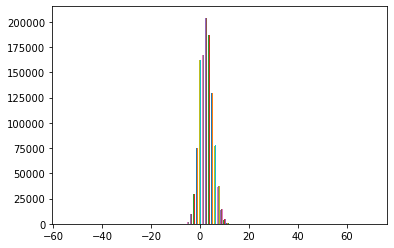

In [16]:
plt.hist(input_pts[:,:,0], bins = 100)
plt.show()

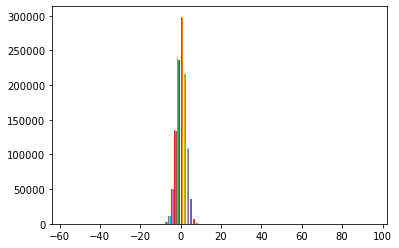

In [17]:
plt.hist(input_pts[:,:,1], bins = 100)
plt.show()

In [12]:
# apply standardization on numerical features
# fit on training data column
scale_dx = StandardScaler().fit(input_pts[:,:,0])
scale_dy = StandardScaler().fit(input_pts[:,:,1])

# transform the training data column
input_pts[:,:,0] = scale_dx.transform(input_pts[:,:,0])
input_pts[:,:,1] = scale_dy.transform(input_pts[:,:,1])

# MinMax scale
scaler_x = MinMaxScaler().fit(input_pts[:,:,2])
scaler_y = MinMaxScaler().fit(input_pts[:,:,3])
scaler_z = MinMaxScaler().fit(input_pts[:,:,4])

# transform
input_pts[:,:,2] = scaler_x.transform(input_pts[:,:,2])
input_pts[:,:,3] = scaler_y.transform(input_pts[:,:,3])
input_pts[:,:,4] = scaler_z.transform(input_pts[:,:,4])

# # transform the testing data column
# X_test_stand[i] = scale.transform(X_test_stand[[i]])

In [13]:
def constructor(model_name="GRU", 
                hidden_state=10,
                lookback=100, 
                input_vars=5,
                output_vars=5,
                loss="mae", 
                optimizer=keras.optimizers.Adam()):
    
    # model instance initialization
    model = keras.models.Sequential()
    
    # add a core layer
    if model_name == "GRU":
        model.add(keras.layers.GRU(hidden_state, return_sequences=False, input_shape=(lookback, input_vars)))
    elif model_name == "LSTM":
        model.add(keras.layers.LSTM(hidden_state, return_sequences=False, input_shape=(lookback, input_vars)))
    
    # add the Dense layer on top
    model.add(keras.layers.Dense(output_vars))
    
    # compilation
    model.compile(loss=loss, optimizer=optimizer)

    return model

In [14]:
m = constructor()
m.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 10)                480       
_________________________________________________________________
dense (Dense)                (None, 5)                 55        
Total params: 535
Trainable params: 535
Non-trainable params: 0
_________________________________________________________________


In [15]:
from tensorflow.keras.callbacks import EarlyStopping

# Create a custom callbacks list consisting of Early Stopping callback
custom_callbacks = [EarlyStopping(monitor='loss',mode='min', patience=3)]

In [16]:
class EarlyStoppingAtMinLoss(keras.callbacks.Callback):
    """Stop training when the loss is at its min, i.e. the loss stops decreasing.
  Arguments:
      patience: Number of epochs to wait after min has been hit. After this
      number of no improvement, training stops.
  """

    def __init__(self, patience=3):
        super(EarlyStoppingAtMinLoss, self).__init__()
        self.patience = patience
        # best_weights to store the weights at which the minimum loss occurs.
        self.best_weights = None

    def on_train_begin(self, logs=None):
        # The number of epoch it has waited when loss is no longer minimum.
        self.wait = 0
        # The epoch the training stops at.
        self.stopped_epoch = 0
        # Initialize the best as infinity.
        self.best = np.Inf

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get("loss")
        if np.less(current, self.best):
            self.best = current
            self.wait = 0
            # Record the best weights if current results is better (less).
            self.best_weights = self.model.get_weights()
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                self.model.stop_training = True
                print("Restoring model weights from the end of the best epoch.")
                self.model.set_weights(self.best_weights)

    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0:
            print("Epoch %05d: early stopping" % (self.stopped_epoch + 1))

In [17]:
logs = m.fit(input_pts,target_pts,batch_size=10000,validation_split=0.25,epochs=1000,
             callbacks=[EarlyStoppingAtMinLoss()])

Train on 825126 samples, validate on 275042 samples
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/1000
825126/825126 [==============================] - 81s 98us/sample - loss: 38515.5784 - val_loss: 36490.3306
Epoch 2/1000
825126/825126 [==============================] - 72s 87us/sample - loss: 38514.3236 - val_loss: 36488.5140
Epoch 3/1000
825126/825126 [==============================] - 71s 85us/sample - loss: 38512.9106 - val_loss: 36487.5843
Epoch 4/1000
825126/825126 [==============================] - 71s 86us/sample - loss: 38512.1109 - val_loss: 36486.8586
Epoch 5/1000
825126/825126 [==============================] - 71s 86us/sample - loss: 38511.4200 - val_loss: 36486.1953
Epoch 6/1000
825126/825126 [==============================] - 72s 88us/sample - loss: 38510.7737 - val_loss: 36485.5629
Epoch 7/1000
825126/825126 [==============================] - 71s 86us/sample - loss: 38510.1509 - val_loss: 36484.9497
Epoch 8/1000
8

In [110]:
train_df['nearest_pts'].shape

(3995951,)